# Setting up Spark Environment

In [13]:
sc = spark.sparkContext

In [14]:
sc

<SparkContext master=yarn appName=PySparkShell>

# Libraries and Modules Installation

In [15]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

# 1. Business Understanding

**Problem Statement-A: ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

**Problem Statement-B: ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะมีพฤติกรรมสุดท้าย (Last hitAction_type) เป็นอะไร เช่น ไม่ซื้อโดยมีพฤติกรรมสุดท้ายเป็นหยิบของใส่ตะกร้าไว้เฉยๆ หรือ ไม่ซื้อโดยมีพฤติกรรมอื่นๆ หรือซื้อสินค้า (Complete purchase)  (Multiclasses Classification)**

**Project Objectitves: (1) ธุรกิจต้องการ Offer อะไรสักอย่างให้ลูกค้าตัดสินใจซื้อได้รวดเร็วขึ้น - มุ่งคนที่ตั้งใจซื้ออยู่แล้ว (2) ธุรกิจต้องการให้เกิดการซื้อเพิ่ม (Up-Selling, Cross-Selling) - มุ่งคนที่ตั้งใจซื้ออยู่แล้ว ให้ซื้อมากขึ้น**

*** Analytics Approach: A, B: Classification => Possible types of Algorithm: Supervised, Information-based, Error-based ***

**Requirement from Business Perspective: (1) ยังไม่ชัดเจนเรื่องข้อมูล รวมถึงคุณภาพข้อมูล (2) ปัจจัยที่มีอิทธิพลต่อการตัดสินใจซื้อหรือเลือกใช้บริการมีอะไรบ้าง และอะไรที่ไม่เกี่ยวข้องกับโจทย์นี้โดยตรงบ้าง**

In [34]:
business_NotRequired_col_list = [\
                        'sessionQualityDim'\
                        ,'timeOnScreen'\
                        ,'hitReferer'
                        ]

business_Required_col_list = [\
                        #'sourceKeyword'\
                        #,'fullVisitorId'\
                        #,'isVideoAd'\
                        #,'date'\
                        #,'isTrueDirect'\
                        #,'hitHour'\
                        #,'hitMin'\
                        #,'isClick'\
                        #,'productListName'\
                        #,'isImpression'\
                        #,'sessionQualityDim'\
                        #'timeOnScreen'\
                        #,'hitReferer'\
                        #,'medium'\
                        #,'hitType'
                        ]

**Success Criteria: ต้องการให้มีการทดลองหลายๆ รอบ แล้วมีการทดสอบกับข้อมูลจริงโดยทีมนักการตลาด ซึ่งหากโมเดลไหน นักการตลาดพอใจก็จะเลือกโมเดลนั้น ในเบื้องต้นกำหนดไว้ว่า โมเดลจะต้องมีค่า Recall ไม่น้อยกว่า 0.7 จึงจะนำเข้าสู่กระบวนการทดสอบโดยนักการตลาดได้**

In [17]:
recallThreshold = 0.7

# 2. Data Understanding

### **2.1 Data Collection and Previewing Data**

In [18]:
! wget https://storage.googleapis.com/class25jan2022/share/testfunnel.csv

--2022-03-05 02:43:11--  https://storage.googleapis.com/class25jan2022/share/testfunnel.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.251.120.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1501012 (1.4M) [text/csv]
Saving to: ‘testfunnel.csv.1’

testfunnel.csv.1    100%[===================>]   1.43M  --.-KB/s    in 0.01s   

2022-03-05 02:43:11 (127 MB/s) - ‘testfunnel.csv.1’ saved [1501012/1501012]



In [19]:
! head -3 testfunnel.csv

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [20]:
! wc -l testfunnel.csv

10000 testfunnel.csv


In [21]:
## สำหรับ Dataproc เท่านั้น
! hdfs dfs -rm -r /rawzone/
! hdfs dfs -mkdir /rawzone/
! hdfs dfs -put testfunnel.csv /rawzone/
! hdfs dfs -ls /rawzone/


Deleted /rawzone
Found 1 items
-rw-r--r--   2 root hadoop    1501012 2022-03-05 02:43 /rawzone/testfunnel.csv


In [22]:
## Spark ทำการ Load & Convert .csv เป็น Spark's DataFrame
source_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('/rawzone/testfunnel.csv')

### 2.2 EDA

### 2.2.1 Univariate Analysis

In [23]:
## มีทั้งหมดกี่ observation
source_df.count()

9999

In [24]:
## ดู Missing Value - NULL ที่ col. count
source_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitReferer,1333,None,None,http://images.google.co.in/imgres?imgurl=https...,https://www.youtube.com/yt/about/press/
hitType,9999,None,None,EVENT,PAGE


In [36]:
## กรองเอาเฉพาะที่ธุรกิจสนใจ หรือมีให้ หรือสำคัญต่อการวิเคราะห์ต่อไป
raw_df = source_df.select([ col for col in source_df.columns if col not in business_NotRequired_col_list ])

In [37]:
raw_df

DataFrame[source: string, isTrueDirect: boolean, sourceKeyword: string, medium: string, isVideoAd: boolean, fullVisitorId: bigint, visitId: int, date: int, newVisits: int, hitType: string, hitAction_type: int, hitNumber: int, hitHour: int, hitMin: int, timeMicroSec: int, v2ProductName: string, productListName: string, isClick: boolean, isImpression: boolean, timeOnSite: int, totalTransactionRevenue: int]

In [38]:
business_NotRequired_col_list

['sessionQualityDim', 'timeOnScreen', 'hitReferer']

In [40]:
len(source_df.columns)

24

In [41]:
len(raw_df.columns)

21

In [43]:
##ตรวจสอบ type ของ var เพื่อทราบว่า เป็น Categorical หรือ Numerical ในแต่ละตัวแปร
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransactionRevenue: integer (nullable = true)



In [49]:
## ใช้ .groupBy().count() ทำการตรวจสอบ Cadinality ของตัวแปร เพื่อคิดต่อในเรื่อง Type of Variables 
## และประเด็นอื่นๆ เช่น Missing with Structural หรือไม่
## ในที่นี้สรุปว่า newVisits เป็นแบบ Discrete Numeric
raw_df.groupBy('newVisits').count().show()

+---------+-----+
|newVisits|count|
+---------+-----+
|     null| 2730|
|        1| 7269|
+---------+-----+



In [48]:
raw_df.groupBy('hitHour').count().show(100)

+-------+-----+
|hitHour|count|
+-------+-----+
|     12|  576|
|     22|  262|
|      1|  158|
|     13|  229|
|     16|  316|
|      6|  268|
|      3|  112|
|     20|  395|
|      5|  319|
|     19|  209|
|     15|  696|
|     17|  356|
|      9|  942|
|      4|  202|
|      8|  686|
|     23|  618|
|      7|  431|
|     10|  847|
|     21|  368|
|     11|  931|
|     14|  492|
|      2|   96|
|      0|  302|
|     18|  188|
+-------+-----+



In [44]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitType,9999,None,None,EVENT,PAGE
hitAction_type,9999,0.13831383138313832,0.6864877640641197,0,6


In [50]:
raw_df.groupBy('totalTransactionRevenue').count().show(1000)

+-----------------------+-----+
|totalTransactionRevenue|count|
+-----------------------+-----+
|               20580000|   28|
|               23990000|   21|
|               33180000|   88|
|               33990000|   90|
|                   null| 9292|
|               59960000|   78|
|               50790000|   55|
|              116760000|   30|
|               34590000|   10|
|               28190000|   20|
|               36980000|   25|
|               30980000|   73|
|              128970000|   20|
|               29980000|  169|
+-----------------------+-----+



In [52]:
## (1) ทำให้เห็นว่า fullVisitorId และ VisitId มี Cardinality ค่อนข้างสูง (จำนวนค่าที่แตกต่างกัน) 
## จึงทำให้ต้องไปดู Distribution ให้แน่ใจอีกครั้ง

## (2) TotolTransactionRevenue มีค่าเป็นหลักล้าน ผิดปกติหรือไม่ อาจต้องไปดู Data Dict.

## (3) hitAction_type เลข 6 เกิดขึ้นทั้งหมด 40 ครั้ง แต่เหตุใดจึงมียอดซื้อ (totalTransactionRevenue >0) 
## เกิดขึ้นมากกว่า 400 ครั้ง จึงทำให้ต้องไปทำ Multivariate ระหว่

for a in raw_df.columns:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+-----+
|              source|count|
+--------------------+-----+
|            (direct)| 4972|
|              google| 4104|
|         youtube.com|  346|
|                 dfa|  185|
|            Partners|   84|
|       images.google|   75|
|          reddit.com|   58|
|analytics.google.com|   45|
|          google.com|   43|
|     blog.golang.org|   39|
|      m.facebook.com|   19|
| images.google.co.in|   12|
|           quora.com|   12|
|                t.co|    2|
|        facebook.com|    2|
|   groups.google.com|    1|
+--------------------+-----+

+------------+-----+
|isTrueDirect|count|
+------------+-----+
|        null| 6648|
|        true| 3351|
+------------+-----+

+--------------------+-----+
|       sourceKeyword|count|
+--------------------+-----+
|                null| 5957|
|      (not provided)| 3940|
|    6qEhsCssdK0z36ri|   65|
|google merchandis...|   13|
| okay google youtube|   12|
|       youtube merch|   12|
+--------------------+-----+

+

In [55]:
## แสดง Frequency Distribution ของ variable ที่สนใจ ในที่นี้สนใจ hitAction_type

all_obs = raw_df.count()


def py_calPercentfunc(origi):
  return (100/all_obs)*origi

calPercentfunc = sparkf.udf(lambda x: py_calPercentfunc(x),DoubleType())


hitAction_type_pd = raw_df.groupBy('hitAction_type').count()\
.withColumn('percentage',calPercentfunc(sparkf.col('count')))\
.orderBy('percentage')\
.toPandas()

In [56]:
## ได้แสดงแบบ ตารางข้อมูลเชิงสรุป
hitAction_type_pd

,hitAction_type,count,percentage
0,4,20,0.200020
1,6,40,0.400040
2,3,59,0.590059
3,5,70,0.700070
4,2,163,1.630163
5,1,210,2.100210
6,0,9437,94.379438


Text(0.5, 0, 'hitAction_type')

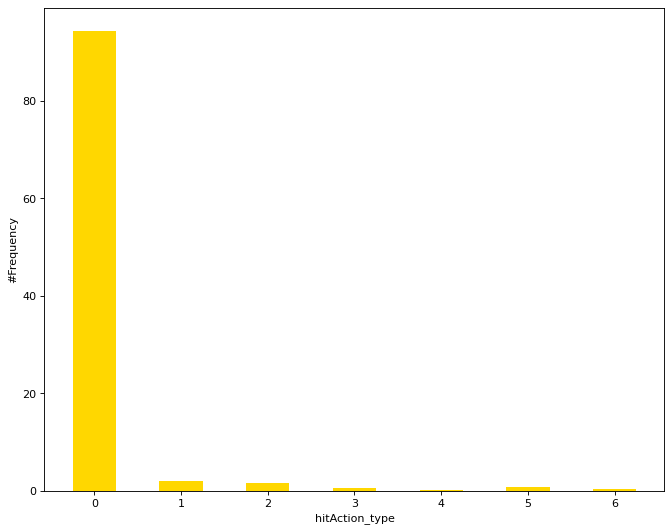

In [57]:
## เห็นว่าตัวแปร hitAction_type ซึ่งอาจจะนำไปเป็น target variable ได้นั้น มีความเป็น imbalance class ค่อนข้างสูง

## Ploting Bars Chart
plt.figure(figsize=(10,8), dpi= 80)
plt.bar(hitAction_type_pd['hitAction_type'], hitAction_type_pd['percentage'], color='gold', width=.5)

## Decoration
plt.ylabel('#Frequency')
plt.xlabel('hitAction_type')


In [58]:
freq_distribution_col_list = ['hitAction_type','hitHour','hitMin','productListName'\
                              ,'v2ProductName']

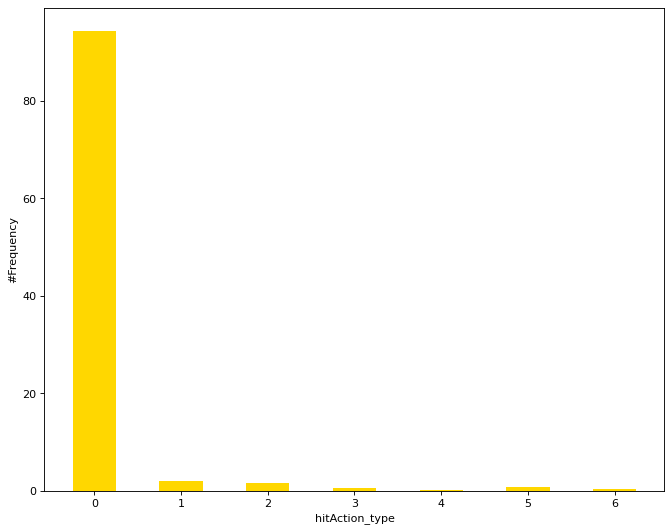

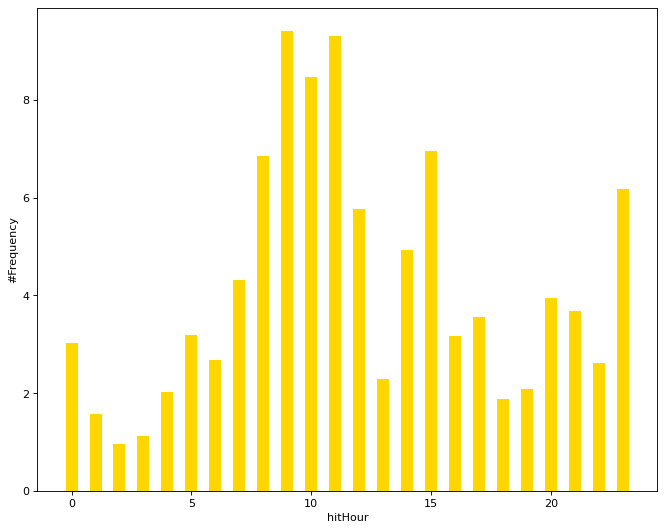

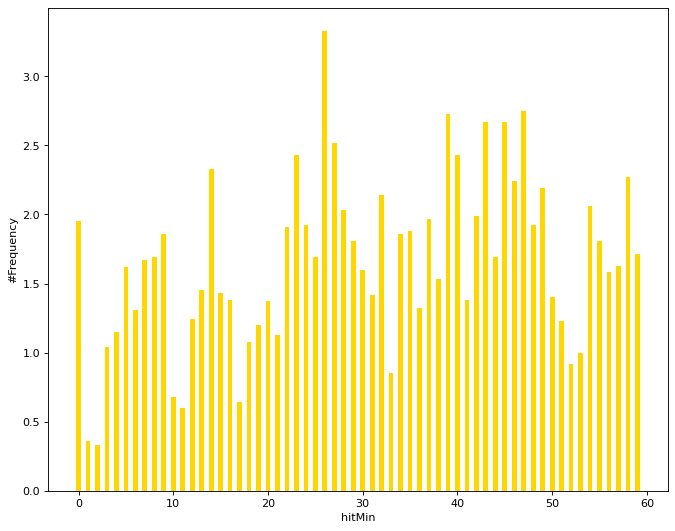

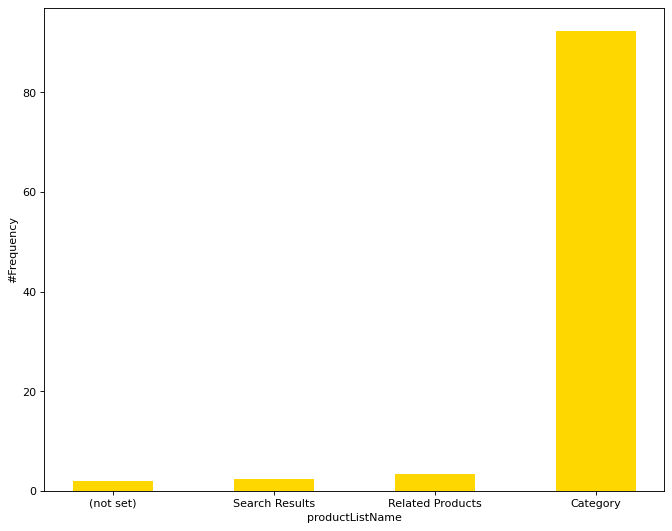

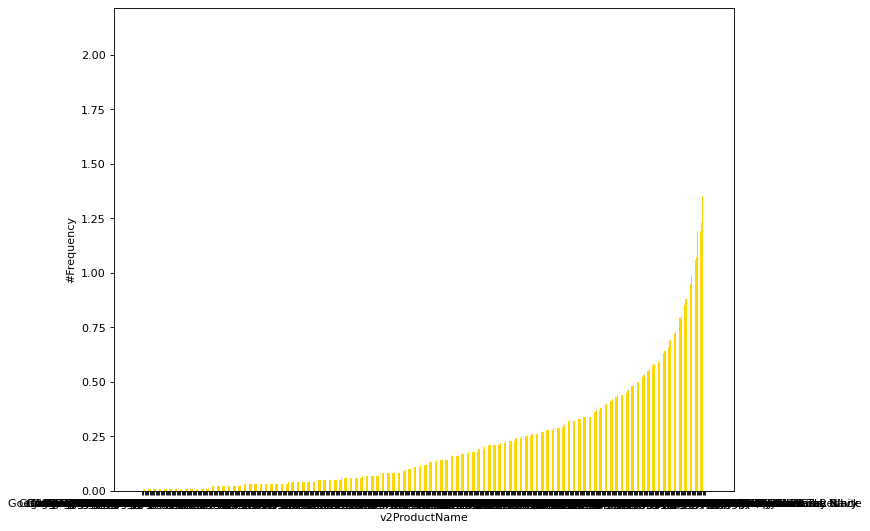

In [59]:
for col in freq_distribution_col_list:
  analysis_pd = raw_df.groupBy(col).count().withColumn('percentage',calPercentfunc(sparkf.col('count')))\
                  .orderBy('percentage')\
                  .toPandas()
  analysis_pd

  ## Ploting Bars Chart
  plt.figure(figsize=(10,8), dpi= 80)
  plt.bar(analysis_pd[col], analysis_pd['percentage'], color='gold', width=.5)

  ## Decoration
  plt.ylabel('#Frequency')
  plt.xlabel(col)

  del(analysis_pd)